In [1]:
import pandas as pd
import seaborn as sns


In [2]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(5)


,subj,bipole,label
0,Epat31,AH3-AH4,1
1,Epat31,AH4-AH5,1
2,Epat31,AH5-AH6,1
3,Epat31,PH1-PH2,1
4,Epat31,PH2-PH3,1


In [3]:
def split_bipole(bip_df: pd.DataFrame):
    """splits the bipole column of a bipole df
    duplicates rows

    """
    assert 'bipole' in bip_df.columns, "Need bipole column!"

    contact1 = bip_df.bipole.apply(lambda x: x.split("-")[1])
    contact2 = bip_df.bipole.apply(lambda x: x.split("-")[1])

    df2 = bip_df.copy(deep=True)

    bip_df['contact'] = contact1
    df2['contact'] = contact2

    return pd.concat([bip_df,df2])

def map_label(label):
    label = int(label)
    match label:
        case 0:
            return "NIZ"
        case 1:
            return 'SOZ'
        case 2:
            return 'PZ'
        case 3:
            return 'IZ'
        
def merge_label(subj_df: pd.DataFrame, label_df: pd.DataFrame, leftcol1: str, rightcol: str, leftcol2='') -> pd.DataFrame:
    """Merges contact label into the subj_df for both stim and response regions

    Args:
        subj_df (pd.DataFrame): dataframe with SPES data, could be CRP, raw SPES, etc
        as long as each row has an entry for a bipole (or monopolar) contact to merge on. 
        ASSUMES 'subj' is a column for sanity checks.
       
        label_df (pd.DataFrame): labels designating 'SOZ', 'NIZ', 'PZ', should be originating 
        from the 'all_pats_bipole.csv', may contain more than one subject, but ASSUMES 'subj' is a column.

        leftcol1 (str): column of subject bipoles, could be stim, or resp, will be renamed
        'leftcol1_label'

        rigthcol (str): column with contact labels to merge into

        leftcol2 (optional): Another column with contacts that need labels attached (in the case of df with stim and resp). 
        For more than 2 columns just call merge_label multiple times. Default is empy str.

    Returns:
        pd.DataFrame: subj df with columns for labels
    """
    assert 'subj' in subj_df.columns, "Need a 'subj' column! in subj_df"
    assert 'subj' in label_df.columns, "Needa 'subj' column in label_df"
    assert 'label' in label_df.columns, "Need a label to merge into subj_df, check label_df!"
    assert len(set(subj_df.subj)) == 1, 'Can only merge one subject at a time!'
    
    subj = subj_df.subj.values[0]
    label_df = label_df[label_df.subj == subj]
    if leftcol2 != '':
        subj_df = subj_df.merge(label_df[[rightcol, 'label']], left_on=leftcol2, right_on=rightcol)
        subj_df.rename(columns={'label':f'{leftcol2}_label'}, inplace=True) #TODO refactor
    subj_df = subj_df.merge(label_df[rightcol, 'label'], left_on=leftcol1, right_on=rightcol)
    subj_df.rename({'label': f'{leftcol1}_label'}, inplace=True)
    return subj_df



label_df = split_bipole(label_df)
label_df.head()
label_df.label = label_df.label.apply(map_label)


In [4]:
RES_FILES = ['/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv','/mnt/ernie_main/Ghassan/ephys/data/Epat27/Epat27_stim.csv',\
             '/mnt/ernie_main/Ghassan/ephys/data/Epat30/Epat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Epat31_stim.csv',\
             '/mnt/ernie_main/Ghassan/ephys/data/Spat30/Spat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat52/Spat52_stim.csv',\
             '/mnt/ernie_main/Ghassan/ephys/data/Spat34/Spat34_stim.csv'
             ]
res_f  = '/mnt/ernie_main/Ghassan/ephys/test/Epat26_stim.csv'
res_df = pd.read_csv(res_f)
subj = res_df.subj.values[0]
label_df = label_df[label_df.subj == subj]

res_df.head(5)

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,stim_reg,ma,subj
0,0,7806.264977,486,LA1,16.062274,LAC3-LAC4,5mA,Epat26
1,1,7552.798081,486,LA1,15.540737,LAC3-LAC4,5mA,Epat26
2,2,7995.722544,486,LA1,16.452104,LAC3-LAC4,5mA,Epat26
3,3,8322.582345,486,LA1,17.124655,LAC3-LAC4,5mA,Epat26
4,4,8446.376098,486,LA1,17.379375,LAC3-LAC4,5mA,Epat26


In [5]:

label_df.head(5)


,subj,bipole,label,contact
319,Epat26,LAC1-LAC2,NIZ,LAC2
320,Epat26,LP1-LP2,PZ,LP2
321,Epat26,LP2-LP3,PZ,LP3
322,Epat26,LTP1-LTP2,SOZ,LTP2
323,Epat26,LTP2-LTP3,SOZ,LTP3


In [6]:
tmp_df = res_df[['stim_reg']].merge(label_df[['bipole','label']], left_on='stim_reg',right_on='bipole')
res_df['stim_label'] = tmp_df['label']
res_df

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,stim_reg,ma,subj,stim_label
0,0,7806.264977,486,LA1,16.062274,LAC3-LAC4,5mA,Epat26,NIZ
1,1,7552.798081,486,LA1,15.540737,LAC3-LAC4,5mA,Epat26,NIZ
2,2,7995.722544,486,LA1,16.452104,LAC3-LAC4,5mA,Epat26,NIZ
3,3,8322.582345,486,LA1,17.124655,LAC3-LAC4,5mA,Epat26,NIZ
4,4,8446.376098,486,LA1,17.379375,LAC3-LAC4,5mA,Epat26,NIZ
...,...,...,...,...,...,...,...,...,...
359635,5,-86.969965,248,RH9,-0.350685,LAM13-LAM14,4mA,Epat26,NIZ
359636,6,-173.554368,248,RH9,-0.699816,LAM13-LAM14,4mA,Epat26,NIZ
359637,7,52.260855,248,RH9,0.210729,LAM13-LAM14,4mA,Epat26,NIZ
359638,8,-2.747961,248,RH9,-0.011080,LAM13-LAM14,4mA,Epat26,NIZ


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='TR'>

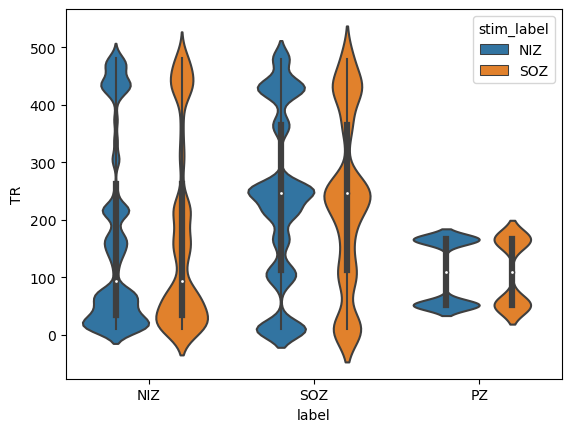

In [7]:

stim_res_df = res_df.merge(label_df[['label','contact']],\
              left_on='resp_reg', right_on='contact')

plot_df = stim_res_df
sns.violinplot(plot_df,x='label', y='TR', hue='stim_label')


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='alpha_prime'>

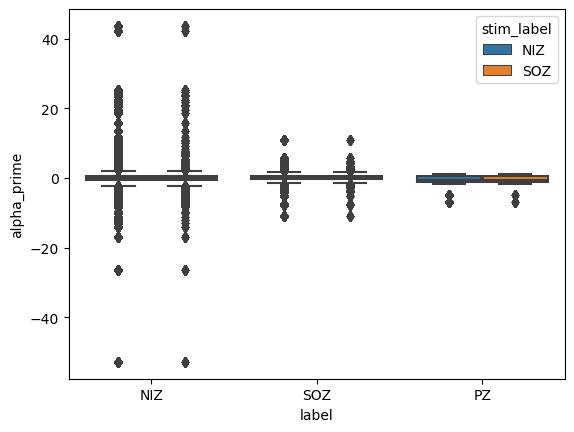

In [18]:
plot_df = plot_df[plot_df.alpha_prime >-350]
sns.boxplot(plot_df,x='label', y='alpha_prime', hue='stim_label')

In [19]:
plot_df[['label','alpha_prime']].groupby("label").mean()

,alpha_prime
label,
NIZ,0.224055
PZ,-0.891111
SOZ,0.113712


In [22]:
plot_df[['label','alpha_prime']].groupby("label").var()

,alpha_prime
label,
NIZ,22.892964
PZ,3.409692
SOZ,4.625036


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='TR', ylabel='alpha_prime'>

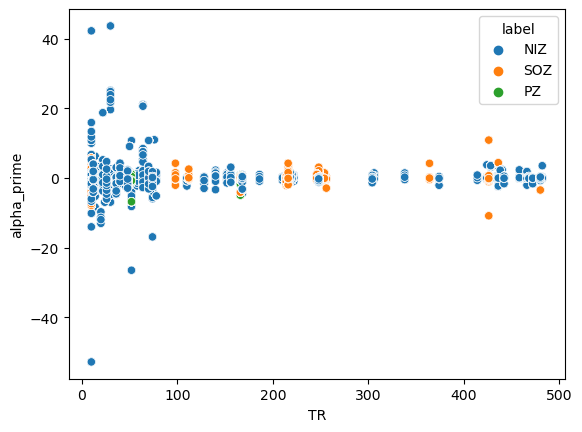

In [23]:
sns.scatterplot(data=plot_df[plot_df.stim_label =='SOZ'], x='TR',y='alpha_prime',hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='TR', ylabel='alpha_prime'>

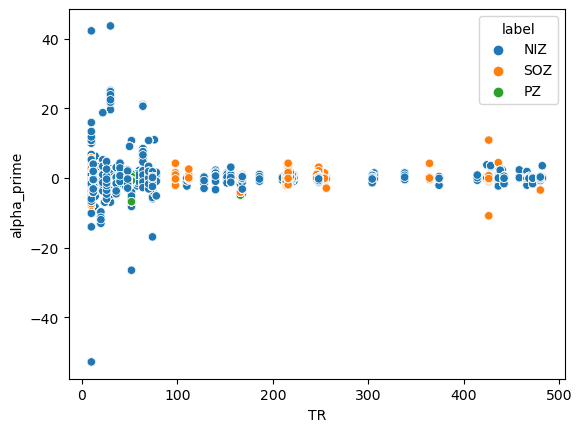

In [24]:
sns.scatterplot(data=plot_df[plot_df.stim_label =='NIZ'], x='TR',y='alpha_prime',hue='label')